# Recommender Systems with Surprise

### Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

#Surprise tools
from surprise import Reader
from surprise import Dataset
from surprise import SVD,SVDpp,KNNBasic,NMF,SlopeOne,CoClustering
from surprise.model_selection import cross_validate
from sklearn.manifold import TSNE

### Reading the Data

In [34]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [35]:
movie_df=pd.read_csv('movies.csv')
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df = pd.merge(movie_df,ratings_df,on='movieId',how='inner')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [36]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


The minimu rating is 0.5 and maximum rating is 5

## Data Visualization

In [49]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: rating, dtype: float64

The movie Gena the Crocodile (1969) is on the top rated movie, but we do nopt know how many people rated that movie.

In [50]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

This counting method gives us the total number of users rated for a particular film. The top rated movie is Forrest Gump (1994).
This movie has been wateched by more than 329 users. 

In [8]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [52]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


The 71 (2014) movie has been rated only by one person and get an average rate of 4. 'Round Midnight (1986) movie rated by 2 users and get an avarge rate 3.5 and so on.

<AxesSubplot: >

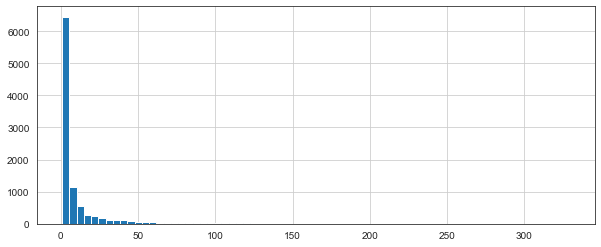

In [53]:
#Lets see the histogram of the number of ratings
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

Almost all movies are rated not more than 4 users.

<AxesSubplot: >

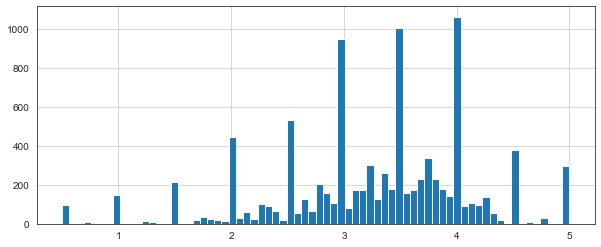

In [54]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

Text(0.5, 6.799999999999994, 'Average ratings')

<Figure size 720x288 with 0 Axes>

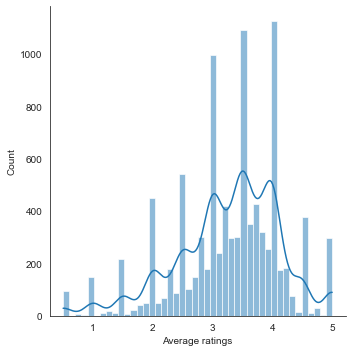

In [55]:
#Seaborn histogram
plt.figure(figsize=(10,4))
sns.displot(data=ratings,x='rating', kind='hist',kde=True)
plt.xlabel('Average ratings')

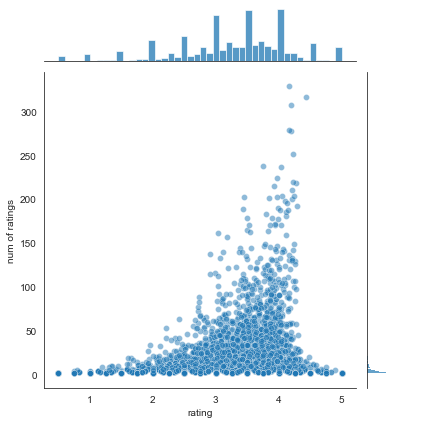

In [56]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

### Creating a Dataset for Surprise

In [37]:
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(ratings_df[['userId','movieId','rating']],reader)

In [38]:
#instantiate the models
fsvd=SVD(n_factors=5,
       n_epochs=1000,
       verbose=False,
         random_state=42)

svdpp=SVDpp(n_factors=2,
           n_epochs=1000,
           random_state=42)

knnbasic=KNNBasic(k=100)

nmf=NMF(n_factors=2,
       n_epochs=1000,
       random_state=42)

slopeone=SlopeOne()

cocluster=CoClustering(n_cltr_u=5,
                      n_cltr_i=5,
                      n_epochs=1000,
                      random_state=42)

### SVD model

In [39]:
#Cross validate the model using the data objects
ssvdcv=cross_validate(algo=fsvd,
               data=data, 
               measures=['rmse'],
               cv=3,
              verbose=False)

In [40]:
ssvdcv

{'test_rmse': array([0.97384163, 0.97624358, 0.9708758 ]),
 'fit_time': (36.8936653137207, 35.903892278671265, 36.11117148399353),
 'test_time': (0.5155763626098633, 0.7030503749847412, 0.49993371963500977)}

In [41]:
fsvdcv_df=pd.DataFrame({'test_rmse':[0.97007522, 0.96939875, 0.96918698],
                       'fit_time':[10.002729177474976, 10.782934188842773, 10.498990535736084],
                       'test_time':[0.12656760215759277, 0.35283327102661133, 0.12451171875]})
fsvdcv_df

,test_rmse,fit_time,test_time
0,0.970075,10.002729,0.126568
1,0.969399,10.782934,0.352833
2,0.969187,10.498991,0.124512


In [14]:
fsvdcv_df.mean()

test_rmse     0.969554
fit_time     10.428218
test_time     0.201304
dtype: float64

### Generating Rating Predictions

In [81]:
fsvd.predict(uid=10, iid=100)

Prediction(uid=10, iid=100, r_ui=None, est=1, details={'was_impossible': False})

### Visualizing the Similarity Between Books Using t-SNE

In [42]:
fsvd.qi.shape

(8365, 5)

In [43]:
tsne = TSNE(n_components=2, n_iter=500, verbose=3, random_state=1)
movies_projected = tsne.fit_transform(fsvd.qi)
projection = pd.DataFrame(columns=['x', 'y'], data=movies_projected)
projection['title'] = movie_df['title']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8365 samples in 0.016s...
[t-SNE] Computed neighbors for 8365 samples in 1.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8365
[t-SNE] Computed conditional probabilities for sample 2000 / 8365
[t-SNE] Computed conditional probabilities for sample 3000 / 8365
[t-SNE] Computed conditional probabilities for sample 4000 / 8365
[t-SNE] Computed conditional probabilities for sample 5000 / 8365
[t-SNE] Computed conditional probabilities for sample 6000 / 8365
[t-SNE] Computed conditional probabilities for sample 7000 / 8365
[t-SNE] Computed conditional probabilities for sample 8000 / 8365
[t-SNE] Computed conditional probabilities for sample 8365 / 8365
[t-SNE] Mean sigma: 0.112919
[t-SNE] Computed conditional probabilities in 0.606s
[t-SNE] Iteration 50: error = 93.5219498, gradient norm = 0.0132055 (50 iterations in 4.904s)
[t-SNE] Iteration 100: error = 90.8786469, gradient norm = 0.0005494 (50 iterations in 4.

In [20]:
projection

,x,y,title
0,19.555662,-7.009352,Toy Story (1995)
1,-9.905551,-5.752976,Jumanji (1995)
2,11.877886,14.213196,Grumpier Old Men (1995)
3,-22.340626,-18.132133,Waiting to Exhale (1995)
4,16.535341,7.105808,Father of the Bride Part II (1995)
...,...,...,...
8363,-8.823358,-16.189831,Date and Switch (2014)
8364,5.839649,20.788881,"Zero Theorem, The (2013)"
8365,8.071890,23.519691,Winter's Tale (2014)
8366,24.363985,4.760621,On the Other Side of the Tracks (De l'autre cô...


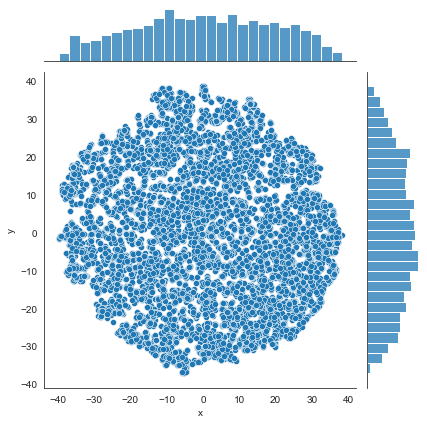

In [44]:
sns.jointplot(data=projection,x='x',y='y', kind='scatter',color=None, palette='coolwarm')
plt.show()

### KNN Basic Model

In [83]:
#Cross validate the model using the data objects
knnbasiccv=cross_validate(algo=knnbasic,
               data=data, 
               measures=['rmse'],
               cv=3,
              verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [84]:
knnbasiccv

{'test_rmse': array([0.96248186, 0.96756082, 0.95885983]),
 'fit_time': (0.06330227851867676, 0.08484292030334473, 0.07769942283630371),
 'test_time': (1.2942686080932617, 1.634314775466919, 1.1661553382873535)}

In [85]:
knncv_df=pd.DataFrame({'test_rmse':[0.96248186, 0.96756082, 0.95885983],
                       'fit_time':[0.06330227851867676, 0.08484292030334473, 0.07769942283630371],
                       'test_time':[1.2942686080932617, 1.634314775466919, 1.1661553382873535]})
knncv_df

,test_rmse,fit_time,test_time
0,0.962482,0.063302,1.294269
1,0.967561,0.084843,1.634315
2,0.958860,0.077699,1.166155


In [86]:
knncv_df.mean()

test_rmse    0.962968
fit_time     0.075282
test_time    1.364913
dtype: float64

### No Negative Matrix Factorization 

In [87]:
#Cross validate the model using the data objects
knmfcv=cross_validate(algo=nmf,
               data=data, 
               measures=['rmse'],
               cv=3,
              verbose=False)

In [88]:
knmfcv

{'test_rmse': array([0.90348684, 0.89902357, 0.89968167]),
 'fit_time': (15.058017253875732, 13.01422643661499, 13.348524808883667),
 'test_time': (0.11276960372924805, 0.2527287006378174, 0.16670465469360352)}

In [89]:
nmfcv_df=pd.DataFrame({'test_rmse':[0.90348684, 0.89902357, 0.89968167],
                       'fit_time':[15.058017253875732, 13.01422643661499, 13.348524808883667],
                       'test_time':[0.11276960372924805, 0.2527287006378174, 0.16670465469360352]})
nmfcv_df

,test_rmse,fit_time,test_time
0,0.903487,15.058017,0.112770
1,0.899024,13.014226,0.252729
2,0.899682,13.348525,0.166705


In [90]:
nmfcv_df.mean()

test_rmse     0.900731
fit_time     13.806923
test_time     0.177401
dtype: float64

### SlpoeOne Model


In [91]:
#Cross validate the model using the data objects
slopeonecv=cross_validate(algo=slopeone,
               data=data, 
               measures=['rmse'],
               cv=3,
              verbose=False)

In [92]:
slopeonecv

{'test_rmse': array([0.9104934 , 0.90473779, 0.91557536]),
 'fit_time': (1.6712992191314697, 1.3257255554199219, 1.3497865200042725),
 'test_time': (4.782657146453857, 4.907818555831909, 4.5770299434661865)}

In [93]:
slopeonecv_df=pd.DataFrame({'test_rmse':[0.9104934 , 0.90473779, 0.91557536],
                       'fit_time':[1.6712992191314697, 1.3257255554199219, 1.3497865200042725],
                       'test_time':[4.782657146453857, 4.907818555831909, 4.5770299434661865]})
slopeonecv_df

,test_rmse,fit_time,test_time
0,0.910493,1.671299,4.782657
1,0.904738,1.325726,4.907819
2,0.915575,1.349787,4.577030


In [94]:
slopeonecv_df.mean()

test_rmse    0.910269
fit_time     1.448937
test_time    4.755835
dtype: float64

### CoClustering Model

In [95]:
#Cross validate the model using the data objects
coclustercv=cross_validate(algo=cocluster,
               data=data, 
               measures=['rmse'],
               cv=3,
              verbose=False)

In [96]:
coclustercv

{'test_rmse': array([0.96137917, 0.95997287, 0.95943802]),
 'fit_time': (89.8466944694519, 85.96856760978699, 80.37910008430481),
 'test_time': (0.10594511032104492, 0.10052347183227539, 0.07810258865356445)}

In [97]:
coclustercv_df=pd.DataFrame({'test_rmse':[0.96137917, 0.95997287, 0.95943802],
                       'fit_time':[89.8466944694519, 85.96856760978699, 80.37910008430481],
                       'test_time':[0.10594511032104492, 0.10052347183227539, 0.07810258865356445]})
coclustercv_df

,test_rmse,fit_time,test_time
0,0.961379,89.846694,0.105945
1,0.959973,85.968568,0.100523
2,0.959438,80.379100,0.078103


In [98]:
coclustercv_df.mean()

test_rmse     0.960263
fit_time     85.398121
test_time     0.094857
dtype: float64

In [113]:
result_df=pd.DataFrame({'Models':['SVD','KNNBasic','NMF','SolpeOne','CoClustering'],
               'test_rmse':[0.969554,0.962968,0.900731,0.910269, 0.960263],
               'fit_time':[10.428218,0.075282,13.806923,1.448937, 85.398121],
               'test_time':[0.201304,1.364913, 0.177401,4.755835, 0.094857]}).set_index('Models')
result_df

,test_rmse,fit_time,test_time
Models,,,
SVD,0.969554,10.428218,0.201304
KNNBasic,0.962968,0.075282,1.364913
NMF,0.900731,13.806923,0.177401
SolpeOne,0.910269,1.448937,4.755835
CoClustering,0.960263,85.398121,0.094857
